# Introduction

In this notebook we try to classify images with a CNN.

Before, we have tried to classify images with a MLP which did not work since MLP do not provide basic operations as pooling in order to foster a translation invariant representation.

# Check dependencies

In [1]:
import matplotlib
print(matplotlib.__version__)

import numpy as np
print(np.__version__)

import cv2
print(cv2.__version__)

import pickle
print(pickle.format_version)

import tensorflow
print(tensorflow.__version__)

3.1.3
1.18.1
4.2.0
4.0
2.0.0


# Load in the image dataset generated before

In [2]:
fname = "../../004_generating_image_data/persons_icons_dataset.pkl"

fobj = open(fname, "rb")
dataset = pickle.load(fobj)
fobj.close()

In [3]:
type(dataset)

list

In [4]:
len(dataset)

2

In [5]:
list_imgs, list_labels = dataset

In [6]:
len(list_imgs)

500

In [7]:
len(list_labels)

500

In [8]:
list_imgs[:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [9]:
list_labels[:2]

[0, 0]

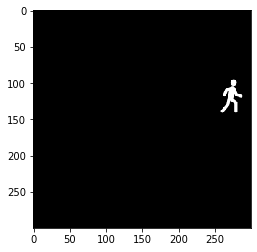

In [10]:
import matplotlib.pyplot as plt

plt.imshow(list_imgs[0], cmap="gray")
plt.show()

In [11]:
label = list_labels[0]
label

0

In [12]:
min(list_labels), max(list_labels)

(0, 4)

In [13]:
nr_object_classes = max(list_labels)+1
nr_object_classes

5

# Prepare input and output matrices

For training a MLP, where the inputs are 1-dimensional we need a 2D-matrix (for batch-learning) in Keras: in each row of this 2D-matrix there was a single input vector stored.

For training a CNN with color images, you need a 4-dimensional input tensor in Keras!

Here is what each of these 4 dimensions is used for:

    dim #1: sample nr
    dim #2: height of the image
    dim #3: width of the image
    dim #4: depth of the image (e.g. 3 color channels; RGB)
    
OK. So let us prepare a 4D input tensor!

In [14]:
example_img = list_imgs[0]

In [15]:
type(example_img)

numpy.ndarray

In [16]:
example_img.shape

(300, 300)

In [17]:
nr_images = len(list_imgs)
nr_images

500

In [18]:
img_height = example_img.shape[0]
img_width  = example_img.shape[1]
img_depth  = 1

In [19]:
X = np.zeros((nr_images, img_height, img_width, img_depth))

In [20]:
X.shape

(500, 300, 300, 1)

In [21]:
X.size

45000000

There it is! A 4D input tensor. But up to now only zeros...

The output tensor on the other hand is still a 2D output tensor: in each row we store for each of the sample images a one-hot encoded vector that encodes which object class is present.

In [22]:
Y = np.zeros((nr_images, nr_object_classes))

In [23]:
def get_one_hot_vec(length, pos):
    vec = np.zeros(length)
    vec[pos] = 1
    return vec

In [24]:
test_vec = get_one_hot_vec(nr_object_classes, 4)
test_vec

array([0., 0., 0., 0., 1.])

In [25]:
for img_nr in range(0, nr_images):
    
    # get the next image
    img = list_imgs[img_nr]
        
    # save image in 4D input tensor
    X[img_nr,:,:,0] = img
    
    # get label (0,1,2,3,or 4)
    label = list_labels[img_nr]
    
    # save label as one-hot encoded vector    
    Y[img_nr,:] = get_one_hot_vec(nr_object_classes, label)

# Split image data into train and test data

In [26]:
N = len(X)
N

500

In [27]:
half = int(N/2)
half

250

In [28]:
X_train = X[:half]
Y_train = Y[:half]

X_test  = X[half:]
Y_test  = Y[half:]

In [29]:
X_train.shape

(250, 300, 300, 1)

In [30]:
X_test.shape

(250, 300, 300, 1)

In [31]:
len(Y_train)

250

In [32]:
len(Y_test)

250

# Build the MLP model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import losses

K.clear_session()

model = Sequential()
model.add(layers.Conv2D(10, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(20, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(30, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(40, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Flatten())

model.add(layers.Dense(10, activation='relu'))
nr_output_neurons = nr_object_classes
model.add(layers.Dense(nr_output_neurons))

model.compile(loss=losses.mean_squared_error, optimizer='sgd')
#model.compile(loss=losses.categorical_crossentropy, optimizer='sgd')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 10)      260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 20)        5020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 30)        15030     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 30)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 40)          3

# Test the model before training

In [34]:
def test_model(model, X_test, Y_test, show_some_predictions=False):
    preds = model.predict(X_test)
    
    nr_test_samples = Y_test.shape[0]
    correct = 0
    for test_nr in range(0,nr_test_samples):        
        should_label = np.argmax(Y_test[test_nr])
        is_label     = np.argmax(preds[test_nr])
        
        if should_label==is_label:
            correct += 1
        
        if show_some_predictions and test_nr<10:
            print("Should: {0} vs. Is: {1}".format(Y_test[test_nr], preds[test_nr]))
            print("Should label: {0} vs. Is label: {1}\n".format(should_label, is_label))            
            
    correctly_classified_percent = (correct / nr_test_samples) * 100.0
    print("Correctly classified: {0:.2f}".format(correctly_classified_percent))

In [35]:
test_model(model, X_test, Y_test, show_some_predictions=True)

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.05796525  0.01883167  0.01414052  0.00682232  0.00999469]
Should label: 2 vs. Is label: 1

Should: [0. 0. 0. 1. 0.] vs. Is: [-0.01648727  0.00198693  0.0101392   0.01187135 -0.00530784]
Should label: 3 vs. Is label: 3

Should: [1. 0. 0. 0. 0.] vs. Is: [-4.2466382e-03 -2.9326978e-03  9.0569351e-04 -3.1046560e-03
  8.8137676e-05]
Should label: 0 vs. Is label: 2

Should: [0. 0. 0. 1. 0.] vs. Is: [-0.01615604  0.00493098  0.01061437  0.01354325 -0.0083531 ]
Should label: 3 vs. Is label: 3

Should: [0. 1. 0. 0. 0.] vs. Is: [-0.02164761  0.00964382  0.00501408 -0.02323043  0.01042957]
Should label: 1 vs. Is label: 4

Should: [0. 0. 0. 1. 0.] vs. Is: [-0.04201383  0.04247887 -0.01516907 -0.01928109  0.00711086]
Should label: 3 vs. Is label: 1

Should: [1. 0. 0. 0. 0.] vs. Is: [-0.01127052  0.01676623  0.0237254   0.01956332 -0.00929204]
Should label: 0 vs. Is label: 2

Should: [0. 0. 0. 1. 0.] vs. Is: [-0.01146162 -0.01383926  0.00572124  0.0019849  -0.000

In [36]:
test_model(model, X_train, Y_train, show_some_predictions=True)

Should: [1. 0. 0. 0. 0.] vs. Is: [-5.15369152e-07  1.12432886e-07 -3.24522134e-08 -3.50952064e-07
  4.98271277e-07]
Should label: 0 vs. Is label: 4

Should: [1. 0. 0. 0. 0.] vs. Is: [-0.00516403 -0.01750967  0.01976806  0.02373879 -0.00114403]
Should label: 0 vs. Is label: 3

Should: [0. 0. 1. 0. 0.] vs. Is: [-1.8513249e-04  2.3363298e-04  3.9340320e-04 -9.0208021e-04
 -7.6040975e-05]
Should label: 2 vs. Is label: 2

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.00226074 -0.00763322  0.01682203  0.01718327  0.01251214]
Should label: 2 vs. Is label: 3

Should: [0. 0. 1. 0. 0.] vs. Is: [-0.02118827  0.01925346 -0.01945742 -0.02356521  0.01865614]
Should label: 2 vs. Is label: 1

Should: [0. 1. 0. 0. 0.] vs. Is: [-0.02890818  0.02442273 -0.00578618 -0.05758639  0.00085289]
Should label: 1 vs. Is label: 1

Should: [1. 0. 0. 0. 0.] vs. Is: [-0.05240176  0.00068616 -0.00312256  0.01576263 -0.02231694]
Should label: 0 vs. Is label: 3

Should: [0. 0. 1. 0. 0.] vs. Is: [-1.8576336e-03 -7.1719987e-03  8.

# Train the CNN

In [37]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 4, 21, 10, 52, 48, 681329)

In [38]:
datetime.now()
history = model.fit(X_train,Y_train, epochs=10000, verbose=1)
datetime.now()

Train on 250 samples
Epoch 1/10000
250/250 [==============================] - 1s 2ms/sample - loss: 0.1996
Epoch 2/10000
250/250 [==============================] - 0s 510us/sample - loss: 0.1944
Epoch 3/10000
250/250 [==============================] - 0s 552us/sample - loss: 0.1902
Epoch 4/10000
250/250 [==============================] - 0s 595us/sample - loss: 0.1867
Epoch 5/10000
250/250 [==============================] - 0s 614us/sample - loss: 0.1837
Epoch 6/10000
250/250 [==============================] - 0s 611us/sample - loss: 0.1811
Epoch 7/10000
250/250 [==============================] - 0s 617us/sample - loss: 0.1788
Epoch 8/10000
250/250 [==============================] - 0s 610us/sample - loss: 0.1767
Epoch 9/10000
250/250 [==============================] - 0s 629us/sample - loss: 0.1749
Epoch 10/10000
250/250 [==============================] - 0s 606us/sample - loss: 0.1733
Epoch 11/10000
250/250 [==============================] - 0s 595us/sample - loss: 0.1719
Epoch 12/10

datetime.datetime(2020, 4, 21, 11, 13, 52, 748682)

In [39]:
type(history)

tensorflow.python.keras.callbacks.History

In [40]:
type(history.history)

dict

In [41]:
history.history

{'loss': [0.19962504613399507,
  0.1943513970375061,
  0.19021671724319458,
  0.18673041915893554,
  0.18369372034072876,
  0.18110054004192352,
  0.1787824788093567,
  0.17673875176906587,
  0.1748954635858536,
  0.17329139757156373,
  0.17186296427249909,
  0.17060251438617707,
  0.1694630686044693,
  0.16844897305965423,
  0.1675536161661148,
  0.16671805000305176,
  0.16595824480056762,
  0.16530152821540833,
  0.16469841027259827,
  0.1641574709415436,
  0.16365636777877807,
  0.16316184067726136,
  0.1627844125032425,
  0.16237801349163056,
  0.16200025963783266,
  0.16166938436031342,
  0.16136509919166564,
  0.16112421798706056,
  0.16083825504779817,
  0.16059571635723113,
  0.1603825763463974,
  0.16018414330482483,
  0.15999034905433654,
  0.15982574343681336,
  0.15966523683071138,
  0.1595061126947403,
  0.1593652971982956,
  0.15923942375183106,
  0.15909261393547058,
  0.15898176324367524,
  0.15887182581424714,
  0.15875606083869934,
  0.1586731983423233,
  0.1585526359

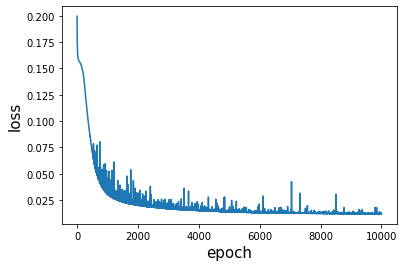

In [42]:
plt.plot(history.history["loss"])
plt.xlabel("epoch", fontsize=15)
plt.ylabel("loss", fontsize=15)
plt.show()

# Test the model after training

In [43]:
test_model(model, X_train, Y_train)

Correctly classified: 94.80


In [44]:
test_model(model, X_test, Y_test)

Correctly classified: 42.00
